# 🏛️ Vesuvius Challenge - Surface Detection Baseline

**Simple 2D Segmentation Approach**

This notebook implements a baseline for the Vesuvius Challenge Surface Detection competition using:
- 2D slicing of 3D TIFF volumes along configurable axis (X, Y, or Z)
- MONAI UNet for 2D segmentation
- PyTorch Lightning for clean training workflow

### 📊 Data Structure

```
vesuvius-challenge-surface-detection/
├── train_images/       # 3D TIFF volumes
│   ├── 1004283650.tif
│   └── ...
├── train_labels/       # 3D mask annotations (same filenames)
│   ├── 1004283650.tif
│   └── ...
└── test_images/        # Test volumes (no labels)
    └── ...
```

In [1]:
!pip install --no-index --find-links="/kaggle/input/surface-detect-package-scraper" -q monai albumentations imagecodecs --no-deps # "numpy==1.26.4" "scipy==1.15.3"
!pip uninstall -q -y tensorflow  # preventing AttributeError

In [2]:
import os
import imagecodecs
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
import tifffile
import albumentations as A
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple, List, Literal, Optional
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from monai.losses import DiceCELoss
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
# Data paths
DATA_DIR = Path("/kaggle/input/vesuvius-challenge-surface-detection")
TRAIN_IMAGES_DIR = DATA_DIR / "train_images"
TRAIN_LABELS_DIR = DATA_DIR / "train_labels"
TEST_IMAGES_DIR = DATA_DIR / "test_images"
OUTPUT_DIR = Path(".")
CACHE_DIR = Path("/kaggle/tmp/dataset_cache")  # Cache for preprocessed slices

# Dataset configuration
SLICE_AXIS: Literal["x", "y", "z"] = "z"  # Axis to slice along
IMAGE_SIZE = (320, 320)                   # Resize slices to this size
USE_CACHE = True                          # Enable caching for faster data loading

# Training configuration
BATCH_SIZE = 36
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3
VAL_SPLIT = 0.1
SEED = 42

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Set seed
pl.seed_everything(SEED)
# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

/usr/local/lib/python3.11/dist-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
Seed set to 42


## 📊 Dataset

The dataset loads 3D TIFF volumes and slices them into 2D samples:
1. Load entire 3D volume (Z, Y, X)
2. Extract slice along chosen axis
3. Stack N adjacent slices as channels (provides 3D context)
4. **Cache slices as .npy files for fast loading**
5. Apply transformations

### 🚀 Caching System

**First run:** Creates cache by extracting all slices from 3D volumes
- Loads each volume once
- Extracts all valid slices with multi-channel context
- Saves as .npy files (fast to load)
- Can take 5-15 minutes depending on data size

**Subsequent runs:** Loads directly from cache
- 10-100x faster than loading full 3D volumes
- No repeated TIFF decompression

**Cache invalidation:** Automatic when you change:
- `SLICE_AXIS`

Set `USE_CACHE = False` to disable caching.

In [3]:
%%writefile vesuvius_dataset.py

import numpy as np
import torch
import tifffile
import multiprocessing
import albumentations as A
from torch.utils.data import Dataset
from tqdm.auto import tqdm
from functools import lru_cache, partial
from pathlib import Path
from typing import Tuple, List, Literal, Optional

class VesuviusSliceDataset(Dataset):
    """Dataset for slicing 3D volumes into 2D segmentation samples.

    Key features:
    - Caches extracted slices as .npy files for fast loading (lazy caching)
    - Can also be prepopulated with a static method.
    - Configurable slice axis (x, y, or z)
    """

    def __init__(
        self,
        images_dir: Path,
        labels_dir: Optional[Path],
        volume_files: List[str],
        slice_axis: Literal["x", "y", "z"] = "z",
        cache_dir: Optional[Path] = None,
        use_cache: bool = True,
        transform: Optional[A.Compose] = None,
    ):
        super().__init__()
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.volume_files = volume_files
        self.slice_axis = slice_axis
        self.cache_dir = cache_dir
        self.use_cache = use_cache
        self.transform = transform

        if self.cache_dir is not None:
            self.cache_dir.mkdir(parents=True, exist_ok=True)

        # The slice_index is now always built in-memory and cached
        print("Building slice index in-memory (using LRU cache)...")
        self.slice_index = self._build_slice_index(
            self.images_dir,
            tuple(self.volume_files), # Convert list to tuple for hashability with lru_cache
            self.slice_axis,
            self.cache_dir # Pass cache_dir here
        )
        print(f"Dataset initialized with {len(self.slice_index)} slices.")

    @staticmethod
    def _map_axis_name_to_index(slice_axis: str) -> int:
        axis_map = {"z": 0, "y": 1, "x": 2}
        return axis_map[slice_axis]

    @staticmethod
    @lru_cache(maxsize=9) # Cache only the most recent set of parameters
    def _build_slice_index(
        images_dir: Path,
        volume_files: Tuple[str, ...],
        slice_axis: Literal["x", "y", "z"],
        cache_dir: Optional[Path] = None, # Added cache_dir argument
    ) -> List[Tuple[str, str, int]]:
        """Build slice index for all volumes (cached static method)."""
        slice_index = []

        for volume_file in tqdm(list(volume_files), desc="Building slice index"):
            num_slices = 0

            if cache_dir is not None:
                volume_stem = Path(volume_file).stem
                marker_dir = cache_dir / volume_stem
                marker_path = marker_dir / f"axis_{slice_axis}.done"

                if marker_path.exists():
                    try:
                        num_slices = int(marker_path.read_text().strip())
                    except ValueError:
                        print(f"Warning: Could not read num_slices from marker file {marker_path}. Falling back to reading TIFF.")
                
            if not num_slices:
                # If cache_dir was None, or marker file didn't exist, or parsing failed
                volume_tiff = tifffile.imread(str(images_dir / volume_file))
                if len(volume_tiff.shape) == 2:
                    num_slices = 1
                else:
                    axis_idx_tiff = VesuviusSliceDataset._map_axis_name_to_index(slice_axis)
                    num_slices = volume_tiff.shape[axis_idx_tiff]

            slice_index += [(volume_file, slice_axis, i) for i in range(num_slices)]

        return slice_index

    @staticmethod
    def _extract_slice_from_volume(
        volume: np.ndarray,
        slice_idx: int,
        axis: Literal["x", "y", "z"]
    ) -> np.ndarray:
        """Extract slice from 3D volume."""
        if len(volume.shape) == 2:
            return volume[np.newaxis, ...]

        if axis == "z":
            slice_2d = volume[slice_idx, :, :]
        elif axis == "y":
            slice_2d = volume[:, slice_idx, :]
        else:  # x
            slice_2d = volume[:, :, slice_idx]

        # Stack as channels (C, H, W)
        return slice_2d[np.newaxis, ...]

    @staticmethod
    def _get_cache_path(cache_dir: Path, volume_file: str, slice_axis: str, slice_idx: int) -> Path:
        """Get path to cached slice file containing both image and mask."""
        volume_stem = Path(volume_file).stem
        filename = f"{slice_axis}_slice-{slice_idx:04d}.npz"
        return cache_dir / volume_stem / filename

    @staticmethod
    def _get_image_and_mask_from_volume(
        image_volume: np.ndarray,
        label_volume: Optional[np.ndarray],
        slice_idx: int,
        slice_axis: str,
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Extract and return image and mask slices (image: uint8, 0-255 range; mask: uint8 integer)."""
        image_slice = VesuviusSliceDataset._extract_slice_from_volume(
            image_volume, slice_idx, slice_axis)

        if label_volume is not None:
            label_slice = VesuviusSliceDataset._extract_slice_from_volume(
                label_volume, slice_idx, slice_axis)
        else:
            # If no label, return a zero mask of the same shape, as integer type
            label_slice = np.zeros(image_slice.shape, dtype=np.uint8)

        # Ensure image_slice is uint8 for caching as per user request
        image_slice = image_slice.astype(np.uint8)

        # Ensure label_slice is an integer type and within expected range (e.g., 0 or 1 or 2)
        label_slice = label_slice.astype(np.uint8)
        assert label_slice.max() <= 2, \
            f"Label values should only be 0, 1, or 2 after processing, found max: {label_slice.max()}"
        return image_slice, label_slice

    def _load_from_raw(
        self,
        volume_file: str,
        slice_axis: str,
        slice_idx: int,
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Helper to load image and mask from raw TIFF files."""
        image_path = self.images_dir / volume_file
        image_volume = tifffile.imread(str(image_path))

        label_volume = None
        if self.labels_dir is not None:
            label_path = self.labels_dir / volume_file
            if label_path.exists():
                label_volume = tifffile.imread(str(label_path))

        image, label_slice = VesuviusSliceDataset._get_image_and_mask_from_volume(
            image_volume, label_volume, slice_idx, slice_axis)
        return image, label_slice

    @staticmethod
    def _save_cache(
        cache_dir: Path,
        volume_file: str,
        slice_axis: str,
        slice_idx: int,
        image_data: np.ndarray,
        mask_data: np.ndarray
    ):
        """Saves image and mask data for a slice to cache."""
        cache_path = VesuviusSliceDataset._get_cache_path(
            cache_dir, volume_file, slice_axis, slice_idx)
        cache_path.parent.mkdir(parents=True, exist_ok=True)

        # Convert to appropriate types for saving (image as uint8, mask as uint8)
        image_to_save = image_data.astype(np.uint8)
        label_to_save = mask_data.astype(np.uint8)

        np.savez_compressed(str(cache_path), image=image_to_save, mask=label_to_save)

    @staticmethod
    def _load_cache(
        cache_dir: Path,
        volume_file: str,
        slice_axis: str,
        slice_idx: int,
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Loads image and mask data for a slice from cache."""
        cache_path = VesuviusSliceDataset._get_cache_path(
            cache_dir, volume_file, slice_axis, slice_idx)
        data = np.load(str(cache_path), allow_pickle=True)
        image = data['image'].astype(np.uint8) # Load image as uint8
        mask = data['mask'].astype(np.uint8)
        return image, mask

    def __len__(self) -> int:
        return len(self.slice_index)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        volume_file, slice_axis, slice_idx = self.slice_index[idx]

        image = None
        label_slice = None

        if self.use_cache and self.cache_dir is not None:
            cache_path = VesuviusSliceDataset._get_cache_path(
                self.cache_dir, volume_file, slice_axis, slice_idx)

            if cache_path.exists():
                image, label_slice = VesuviusSliceDataset._load_cache(
                    self.cache_dir, volume_file, slice_axis, slice_idx)
            else:
                image, label_slice = self._load_from_raw(volume_file, slice_axis, slice_idx)
                VesuviusSliceDataset._save_cache(
                    self.cache_dir, volume_file, slice_axis, slice_idx, image, label_slice)
        else:
            image, label_slice = self._load_from_raw(volume_file, slice_axis, slice_idx)

        # Convert image to float32 and normalize to 0-1 range here
        image = image.astype(np.float32) / 255.0

        image = np.transpose(image, (1, 2, 0))
        label_slice = label_slice.squeeze(0)

        if self.transform is not None:
            transformed = self.transform(image=image, mask=label_slice)
            image = transformed["image"]
            label_slice = transformed["mask"]
        else:
            # Convert numpy array to PyTorch tensor and reorder dimensions for PyTorch (C, H, W)
            image = torch.from_numpy(image).permute(2, 0, 1)
            label_slice = torch.from_numpy(label_slice).unsqueeze(0)

        # The `label_slice` passed to `DiceCELoss` will now contain 0, 1, or 2.
        # `DiceCELoss` will handle the `ignore_index`.
        return image.float(), label_slice.float()

    @staticmethod
    def _process_volume_for_cache(
        volume_file: str,
        images_dir: Path,
        labels_dir: Optional[Path],
        slice_axis: str,
        cache_dir: Path
    ) -> List[Tuple[str, str, int]]:
        """Helper function to process a single volume for cache creation (static)."""

        volume_stem = Path(volume_file).stem
        marker_dir = cache_dir / volume_stem
        marker_path = marker_dir / f"axis_{slice_axis}.done"

        if marker_path.exists():
            # If the marker exists, we can optionally read the number of slices from it
            # but for now, we just skip re-processing.
            print(f"Cache for {volume_file} along axis {slice_axis} already exists. Skipping.")
            return [] # Return empty list if already cached

        image_path = images_dir / volume_file
        image_volume = tifffile.imread(str(image_path))

        label_volume = None
        if labels_dir is not None:
            label_path = labels_dir / volume_file
            if label_path.exists():
                label_volume = tifffile.imread(str(label_path))

        if len(image_volume.shape) == 2:
            num_slices = 1
        else:
            axis_idx = VesuviusSliceDataset._map_axis_name_to_index(slice_axis)
            num_slices = image_volume.shape[axis_idx]

        slice_entries = []
        for slice_idx in range(num_slices):
            image_slice, label_slice = VesuviusSliceDataset._get_image_and_mask_from_volume(
                image_volume, label_volume, slice_idx, slice_axis)

            VesuviusSliceDataset._save_cache(
                cache_dir, volume_file, slice_axis, slice_idx, image_slice, label_slice)
            slice_entries.append((volume_file, slice_axis, slice_idx))

        # Create a marker file to indicate that caching for this volume and axis is done
        marker_dir.mkdir(parents=True, exist_ok=True) # Ensure directory exists
        marker_path.write_text(str(num_slices)) # Store the number of slices in the marker file

        return slice_entries

    @staticmethod
    def clear_done_markers(
        cache_dir: Path,
        slice_axis: Literal["x", "y", "z"]
    ) -> None:
        """Deletes all '.done' marker files for a specific slice_axis from cache subfolders."""
        print(f"Clearing '.done' markers for slice_axis='{slice_axis}' in {cache_dir}...")
        if not cache_dir.exists():
            print("Cache directory does not exist, nothing to clear.")
            return

        count = 0
        for subdir in cache_dir.iterdir():
            marker_path = subdir / f"axis_{slice_axis}.done"
            if not marker_path.exists():
                continue
            marker_path.unlink() # Delete the file
            count += 1
        print(f"Cleared {count} marker files for slice_axis='{slice_axis}'.")

    @staticmethod
    def prepopulate_cache(
        images_dir: Path,
        labels_dir: Optional[Path],
        slice_axis: Literal["x", "y", "z"],
        cache_dir: Path,
        volume_files: Optional[List[str]] = None,
        num_processes: int = -1,
    ) -> None:
        """Statically prepopulate the entire slice cache using multiprocessing."""
        if not cache_dir:
            raise ValueError("cache_dir must be provided for prepopulating cache.")
        if not images_dir.exists():
            raise ValueError(f"Images directory {images_dir} does not exist.")

        cache_dir.mkdir(parents=True, exist_ok=True)

        # Clear existing done markers for the current slice_axis to ensure a fresh cache for this axis
        VesuviusSliceDataset.clear_done_markers(cache_dir, slice_axis)

        if num_processes < 0:
            num_processes = multiprocessing.cpu_count()

        if volume_files is None:
            # If volume_files are not provided, discover all .tif files in the directory
            volume_files = sorted([f.name for f in images_dir.glob("*.tif")])
        if not volume_files:
            raise ValueError(
                f"No TIFF files found in {images_dir} or `volume_files` was not provided.")

        # Use functools.partial to fix common arguments for the multiprocessing function
        process_func = partial(
            VesuviusSliceDataset._process_volume_for_cache,
            images_dir=images_dir,
            labels_dir=labels_dir,
            slice_axis=slice_axis,
            cache_dir=cache_dir
        )

        print(f"Prepopulating cache for {len(volume_files)} volumes using {num_processes} processes...")
        all_slice_index = []
        with multiprocessing.Pool(processes=num_processes) as pool:
            # Now, imap_unordered only needs to iterate over the unique argument: volume_file
            for volume_slices in tqdm(
                pool.imap_unordered(process_func, volume_files),
                total=len(volume_files),
                desc="Prepopulating cache",
            ):
                all_slice_index.extend(volume_slices)

        print(f"Cache prepopulated with {len(all_slice_index)} slices. No master index file saved.")

Writing vesuvius_dataset.py


In [4]:
def visualize_sample(
    dataset,  # VesuviusSliceDataset
    idx: int,
    figsize: Tuple[int, int] = (18, 5) # Increased figsize for colorbar
):
    """Visualize a sample from the dataset."""
    # Import mark_boundaries here as requested
    from skimage.segmentation import mark_boundaries

    image, mask = dataset[idx]

    # Convert to numpy
    image = image.cpu().numpy()
    mask = mask.cpu().numpy()

    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Calculate mid_channel for display
    mid_channel = image.shape[0] // 2

    axes[0].imshow(image[mid_channel], cmap='gray')
    axes[0].set_title(f'Image (channel {mid_channel}/{image.shape[0]})')
    axes[0].axis('off')

    # Display image with mask contours overlaid
    # Ensure the image for mark_boundaries is 2D and normalized for display
    img4contour = image[mid_channel].copy()
    if img4contour.max() > 1.0:
        img4contour = img4contour / img4contour.max()

    # mark_boundaries expects a binary mask (0 or 1)
    # It will treat any non-zero value as foreground. So, '2' will be treated as foreground.
    binary_mask = (mask > 0).astype(int)
    contoured_image = mark_boundaries(
        img4contour, binary_mask, outline_color=(1, 0, 0))
    axes[1].imshow(contoured_image)
    axes[1].set_title('Image with Mask Contours (2 treated as 1)')
    axes[1].axis('off')

    # Show mask with clarification for label-to-color mapping and add colorbar
    # Setting vmin=0, vmax=2 to visualize all 3 possible labels (0, 1, 2)
    im = axes[2].imshow(mask, cmap='hot', vmin=0, vmax=2)
    axes[2].set_title('Ground Truth Mask (0: Bg, 1: Fg, 2: Ignored)')
    axes[2].axis('off')

    # Add colorbar
    cbar = fig.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 1, 2])
    cbar.set_ticklabels(['0 (Background)', '1 (Foreground)', '2 (Ignored)'])
    cbar.set_label('Label Value')

    plt.tight_layout()
    plt.show()

In [5]:
from vesuvius_dataset import VesuviusSliceDataset

VesuviusSliceDataset.prepopulate_cache(
    images_dir=TRAIN_IMAGES_DIR,
    labels_dir=TRAIN_LABELS_DIR,
    slice_axis=SLICE_AXIS,
    cache_dir=CACHE_DIR,
)

Clearing '.done' markers for slice_axis='z' in /kaggle/tmp/dataset_cache...
Cleared 0 marker files for slice_axis='z'.
Prepopulating cache for 806 volumes using 4 processes...


Prepopulating cache:   0%|          | 0/806 [00:00<?, ?it/s]

Cache prepopulated with 254912 slices. No master index file saved.


## 🔄 DataModule

PyTorch Lightning DataModule handles data loading and splitting:

In [6]:
class VesuviusDataModule(pl.LightningDataModule):
    """DataModule for train/val split and data loading."""

    def __init__(
        self,
        images_dir: Path,
        labels_dir: Path,
        slice_axis: Literal["x", "y", "z"],
        image_size: Tuple[int, int],
        cache_dir: Optional[Path],
        use_cache: bool,
        batch_size: int,
        val_split: float,
        num_workers: int = -1,
        seed: int = 42,
    ):
        super().__init__()
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.slice_axis = slice_axis
        self.image_size = image_size
        self.cache_dir = cache_dir
        self.use_cache = use_cache
        self.batch_size = batch_size
        if num_workers <= 0:
            num_workers = min(8, os.cpu_count())
        self.num_workers = num_workers
        self.val_split = val_split
        self.seed = seed

    def setup(self, stage: Optional[str] = None):
        """Setup datasets."""
        # Get all TIFF files
        volume_files = sorted([f.name for f in self.images_dir.glob("*.tif")])

        if not volume_files:
            raise ValueError(f"No TIFF files found in {self.images_dir}")

        print(f"Found {len(volume_files)} volume files")

        # Split into train/val
        train_files, val_files = train_test_split(
            volume_files, test_size=self.val_split, random_state=self.seed
        )

        print(f"Train: {len(train_files)} volumes, Val: {len(val_files)} volumes")

        # Create transforms
        self.train_transform = A.Compose([
            A.Resize(height=self.image_size[0], width=self.image_size[1]),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            # A.RandomRotate90(p=0.5),
            # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.MultiplicativeNoise(multiplier=(0.9, 1.1), elementwise=True, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
            A.Normalize(mean=[0.5], std=[0.5]),
            ToTensorV2(),
        ])
        self.val_transform = A.Compose([
            A.Resize(height=self.image_size[0], width=self.image_size[1]),
            A.Normalize(mean=[0.5], std=[0.5]),
            ToTensorV2(),
        ])

        # Create datasets
        self.train_dataset = VesuviusSliceDataset(
            images_dir=self.images_dir,
            labels_dir=self.labels_dir,
            volume_files=train_files,
            slice_axis=self.slice_axis,
            cache_dir=self.cache_dir,
            use_cache=self.use_cache,
            transform=self.train_transform,
        )
        self.val_dataset = VesuviusSliceDataset(
            images_dir=self.images_dir,
            labels_dir=self.labels_dir,
            volume_files=val_files,
            slice_axis=self.slice_axis,
            cache_dir=self.cache_dir,
            use_cache=self.use_cache,
            transform=self.val_transform,
        )

        print(f"Train dataset: {len(self.train_dataset)} slices")
        print(f"Val dataset: {len(self.val_dataset)} slices")

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
        )

In [7]:
# Create data module
data_module = VesuviusDataModule(
    images_dir=TRAIN_IMAGES_DIR,
    labels_dir=TRAIN_LABELS_DIR,
    slice_axis=SLICE_AXIS,
    image_size=IMAGE_SIZE,
    cache_dir=CACHE_DIR,
    use_cache=USE_CACHE,
    batch_size=BATCH_SIZE,
    val_split=VAL_SPLIT,
    seed=SEED,
)
data_module.setup()

Found 806 volume files
Train: 725 volumes, Val: 81 volumes
Building slice index in-memory (using LRU cache)...


Building slice index:   0%|          | 0/725 [00:00<?, ?it/s]

Dataset initialized with 229248 slices.
Building slice index in-memory (using LRU cache)...


Building slice index:   0%|          | 0/81 [00:00<?, ?it/s]

Dataset initialized with 25664 slices.
Train dataset: 229248 slices
Val dataset: 25664 slices


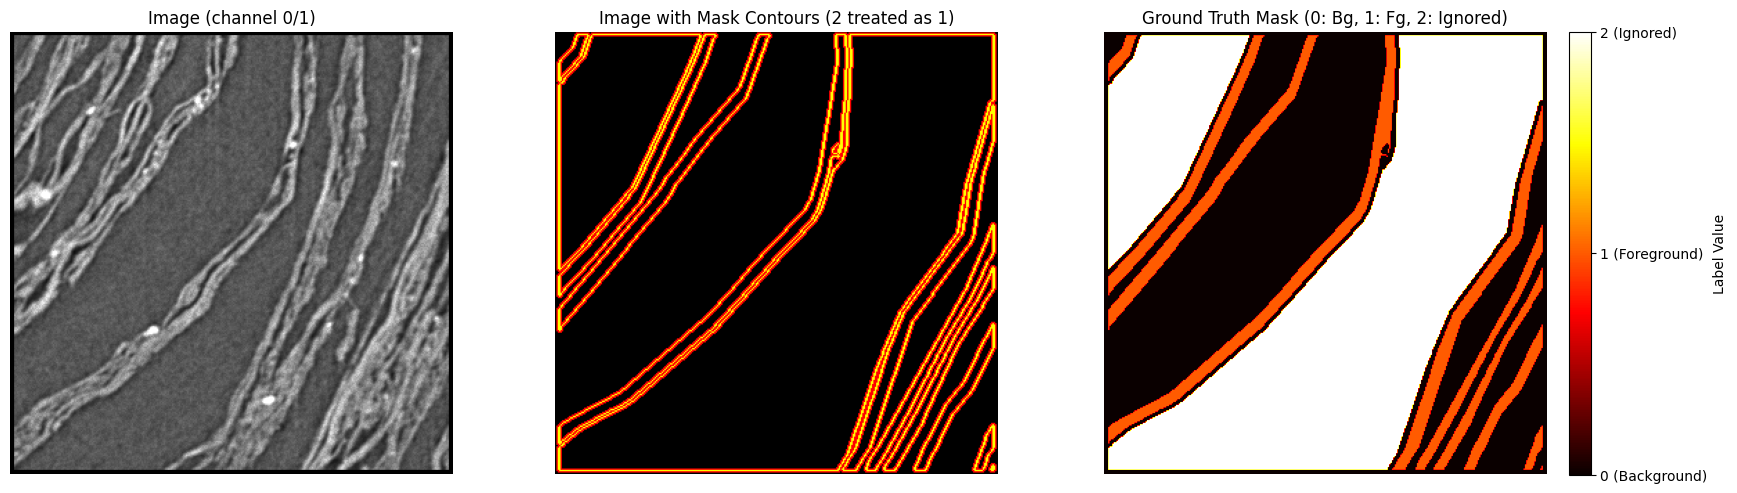

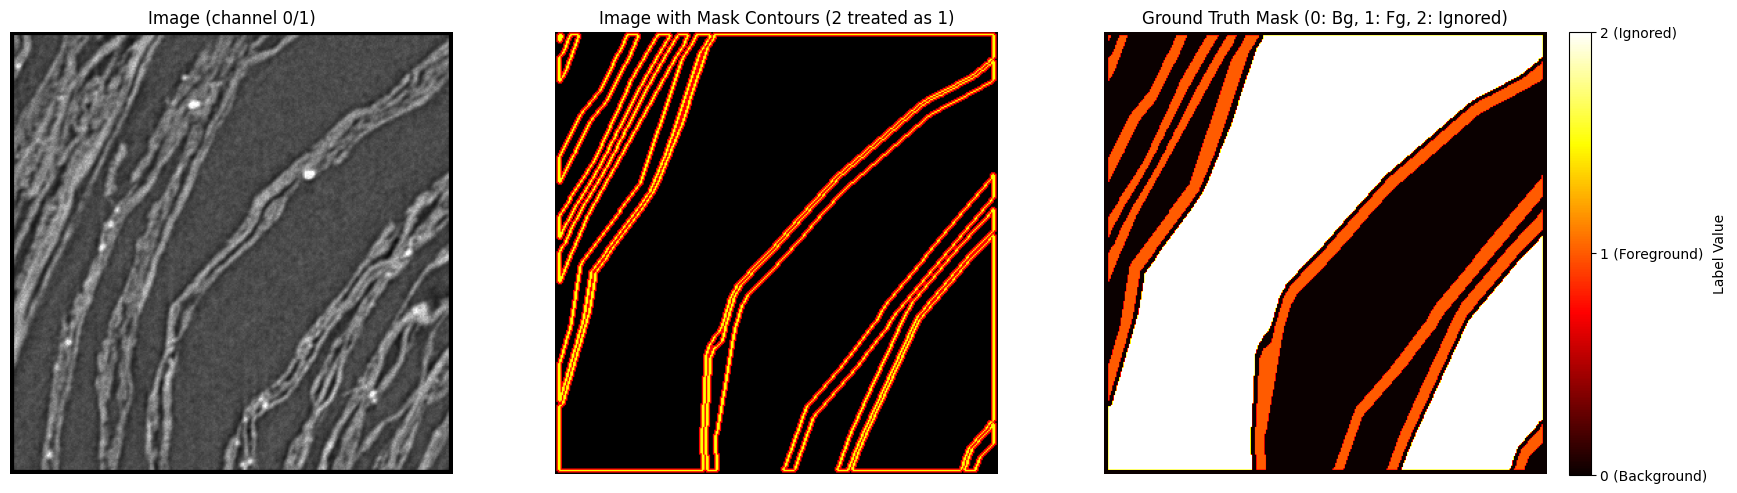

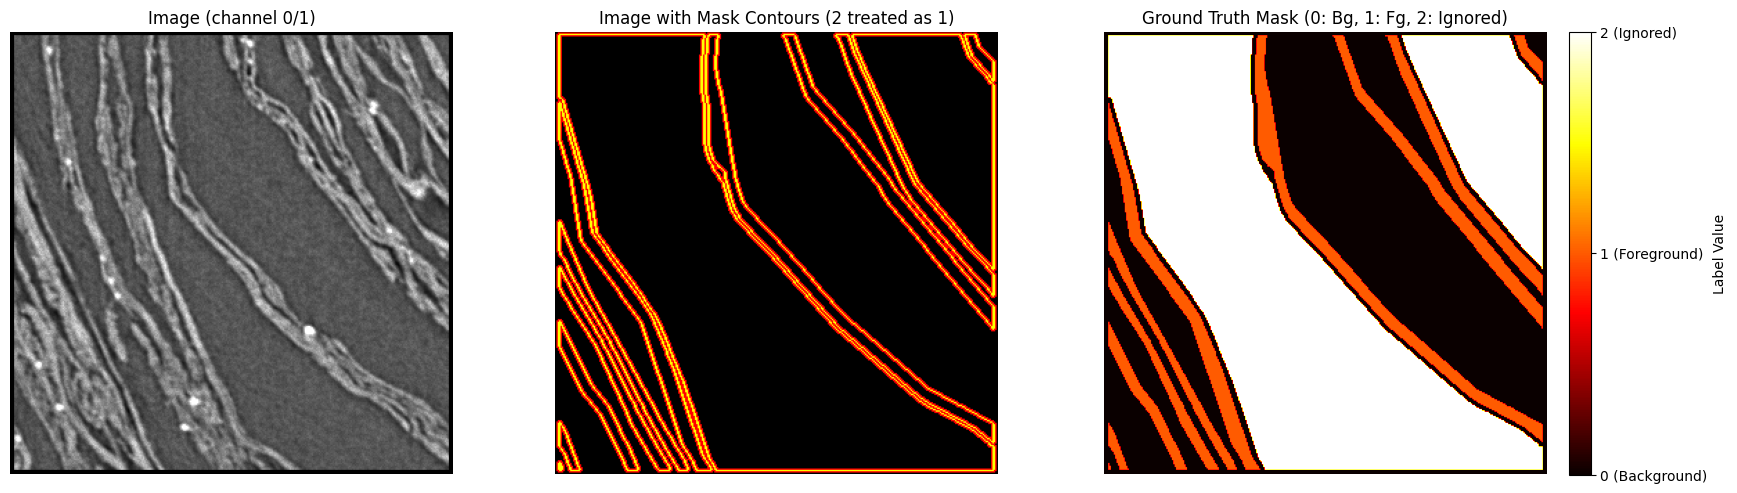

In [8]:
# Visualize samples
for i in range(3):
    visualize_sample(data_module.train_dataset, i)

## 🧠 Model - MONAI

MONAI UNet wrapped in PyTorch Lightning module:

In [9]:
import torch.nn.functional as F

class VesuviusSegmentationModel(pl.LightningModule):
    """2D segmentation model with MONAI UNet.

    Architecture:
    - Multi-level encoder-decoder (UNet)
    - Skip connections for detail preservation
    - Residual blocks at each level
    """

    def __init__(
        self,
        net_module: nn.Module,
        out_channels: int = 2,
        learning_rate: float = 1e-3,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        # Class label to be ignored in loss calculation
        self.ignore_index_val = 2
        self.module = net_module
        self.out_channels = out_channels

        # DiceCELoss configured for binary segmentation (2 classes) without `ignore_index` argument.
        # We will manually handle ignored labels by manipulating the target masks.
        self.criterion = DiceCELoss(
            softmax=True,
            to_onehot_y=False, # We will manually create one-hot targets
            lambda_dice=0.5,
            lambda_ce=0.5,
            include_background=True,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.module(x)

    def _compute_metrics(self, preds_logits: torch.Tensor, targets_class_indices: torch.Tensor) -> dict:
        """Compute multi-class (now binary) Dice and IoU metrics.
        preds_logits: (B, C, H, W) raw logits from the module.
        targets_class_indices: (B, 1, H, W) with class labels (0, 1, or 2).
        """
        # Convert logits to probabilities (B, C, H, W)
        preds_proba = torch.softmax(preds_logits, dim=1)
        # Get hard predictions (class indices) (B, 1, H, W)
        preds_hard = torch.argmax(preds_proba, dim=1, keepdim=True)

        # Create a mask to ignore pixels with the ignore_index (2)
        valid_mask = (targets_class_indices != self.ignore_index_val).float() # (B, 1, H, W)

        num_classes = preds_logits.shape[1] # This will be 2 (background, foreground)
        dice_scores_per_class = []
        iou_scores_per_class = []

        for i in range(num_classes):
            # Create binary masks for the current class 'i'
            pred_class_i = (preds_hard == i).float() # (B, 1, H, W)
            target_class_i = (targets_class_indices == i).float() # (B, 1, H, W)

            # Apply valid_mask to only consider pixels that are not ignored
            pred_class_i_valid = pred_class_i * valid_mask
            target_class_i_valid = target_class_i * valid_mask

            intersection = (pred_class_i_valid * target_class_i_valid).sum()
            union_sum_dice = pred_class_i_valid.sum() + target_class_i_valid.sum()
            union_sum_iou = pred_class_i_valid.sum() + target_class_i_valid.sum() - intersection

            # Handle cases where union might be zero for a class (e.g., no foreground in valid pixels)
            dice = (2 * intersection + 1e-8) / (union_sum_dice + 1e-8)
            iou = (intersection + 1e-8) / (union_sum_iou + 1e-8)

            dice_scores_per_class.append(dice)
            iou_scores_per_class.append(iou)

        # Average over both classes (background and foreground) where valid pixels exist
        mean_dice = torch.mean(torch.stack(dice_scores_per_class))
        mean_iou = torch.mean(torch.stack(iou_scores_per_class))

        return {"dice": mean_dice, "iou": mean_iou}

    def _step(self, batch: Tuple[torch.Tensor, torch.Tensor], prefix: str) -> torch.Tensor:
        """Common step logic for training and validation."""
        images, masks = batch # masks are (B, 1, H, W) with 0, 1, or 2
        logits = self(images) # logits are (B, 2, H, W)

        if masks.ndim == 3:
            masks = masks.unsqueeze(1) # ensure (B, 1, H, W)

        # Prepare target for DiceCELoss: manually create one-hot tensor and zero out ignored regions.
        masks_long_for_onehot = masks.long().squeeze(1) # (B, H, W) with 0, 1, 2

        # Temporarily replace ignore_index_val (2) with 0 for F.one_hot to avoid error
        # The effect of ignoring will come from zeroing out the one-hot vectors later.
        temp_masks_for_onehot = masks_long_for_onehot.clone()
        temp_masks_for_onehot[temp_masks_for_onehot == self.ignore_index_val] = 0

        # Create one-hot target for the 2 module output channels (0 and 1)
        target_one_hot = F.one_hot(temp_masks_for_onehot, num_classes=self.out_channels).permute(0, 3, 1, 2).float()

        # Create a mask for the actual ignored pixels from the original masks_long_for_onehot
        # (B, 1, H, W) -> (B, 1, H, W) float
        ignore_mask_for_target = (masks_long_for_onehot == self.ignore_index_val).unsqueeze(1).float()

        # Zero out the one-hot target entries where pixels are ignored
        target_one_hot = target_one_hot * (1 - ignore_mask_for_target) # (B, 2, H, W)

        # Compute loss using the manually prepared one-hot target
        loss = self.criterion(logits, target_one_hot)

        # Metrics are computed using the original masks, which still contain the ignore_index_val
        metrics = self._compute_metrics(logits, masks)

        self.log(f"{prefix}_loss", loss, prog_bar=True)
        self.log(f"{prefix}_dice", metrics["dice"], prog_bar=True)
        self.log(f"{prefix}_iou", metrics["iou"])
        return loss

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        return self._step(batch, "train")

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        return self._step(batch, "val")

    def configure_optimizers(self):
        # Using AdamW with ReduceLROnPlateau for adaptive learning rate adjustment
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-2)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="max",
            factor=0.5,
            patience=2,
            min_lr=1e-6,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "monitor": "val_dice", # ReduceLROnPlateau needs a metric to monitor
            }
        }

In [10]:
from monai.networks.nets import UNet, AttentionUnet, SegResNet


# Model architecture
# MODEL_CHANNELS = (32, 64, 128, 256, 512)   # UNet channel progression
# MODEL_STRIDES = (2, 2, 2, 2)              # Downsampling strides
# net = UNet(
#     spatial_dims=2,
#     in_channels=1,
#     out_channels=2,
#     channels=MODEL_CHANNELS,
#     strides=MODEL_STRIDES,
#     num_res_units=6,  # for Unet only
#     dropout=0.2,
# )

net = SegResNet(
    spatial_dims=2,  # 2D segmentation
    in_channels=1,  # Single 2D slice as input
    out_channels=2,  # Binary segmentation (foreground/background)
    init_filters=32,  # Start with 32 filters (can go 16/32/48)
    blocks_down=(1, 2, 2, 4),  # Encoder depth
    blocks_up=(1, 1, 1),  # Decoder depth
    dropout_prob=0.2,  # Regularization
    norm=("GROUP", {"num_groups": 8}),
    act=("RELU", {"inplace": True}),
    use_conv_final=True
)

# Create model
model = VesuviusSegmentationModel(
    net_module=net,
    learning_rate=LEARNING_RATE,
)

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/parsing.py:210: Attribute 'net_module' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net_module'])`.


## 🏋️ Lit Training

Main training pipeline:

In [11]:
from pytorch_lightning.loggers import CSVLogger

# Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath=OUTPUT_DIR,
    filename="vesuvius-{epoch:02d}-{val_dice:.4f}",
    monitor="val_dice",
    mode="max",
    save_top_k=3,
)

early_stop_callback = EarlyStopping(
    monitor="val_dice",
    patience=8,
    mode="max",
)

# Instantiate CSVLogger
csv_logger = CSVLogger(save_dir=OUTPUT_DIR)

# Trainer
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    accelerator="auto",
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=csv_logger, # Add csv_logger to the Trainer
    log_every_n_steps=5,
    limit_train_batches=0.4,
    limit_val_batches=0.5,
    accumulate_grad_batches=3,
    val_check_interval=0.5, # Run validation four times per epoch
    precision='16-mixed', # Enable mixed precision training
)

# Train
trainer.fit(model, data_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /kaggle/working exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found 806 volume files
Train: 725 volumes, Val: 81 volumes
Building slice index in-memory (using LRU cache)...
Dataset initialized with 229248 slices.
Building slice index in-memory (using LRU cache)...
Dataset initialized with 25664 slices.
Train dataset: 229248 slices
Val dataset: 25664 slices


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | module    | SegResNet  | 6.3 M  | train
1 | criterion | DiceCELoss | 0      | train
-------------------------------------------------
6.3 M     Trainable params
0         Non-trainable params
6.3 M     Total params
25.194    Total estimated model params size (MB)
141       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Loading metrics from: lightning_logs/version_0/metrics.csv


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,epoch,step,train_dice,train_iou,train_loss,val_dice,val_iou,val_loss
0,0,4,0.417475,0.358332,0.494702,NaN,NaN,NaN
1,0,9,0.420715,0.363133,0.489895,NaN,NaN,NaN
2,0,14,0.428785,0.375327,0.479282,NaN,NaN,NaN
3,0,19,0.423362,0.367095,0.482746,NaN,NaN,NaN
4,0,24,0.414834,0.354459,0.480145,NaN,NaN,NaN


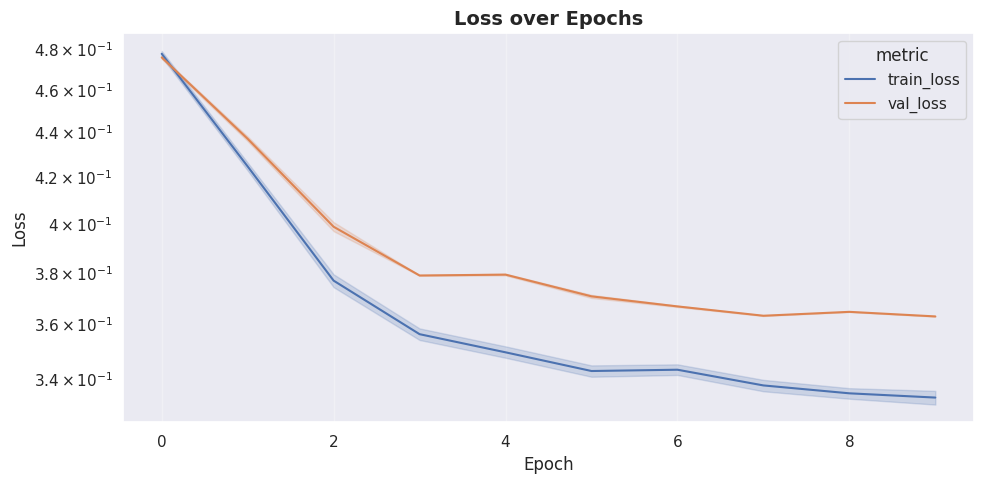

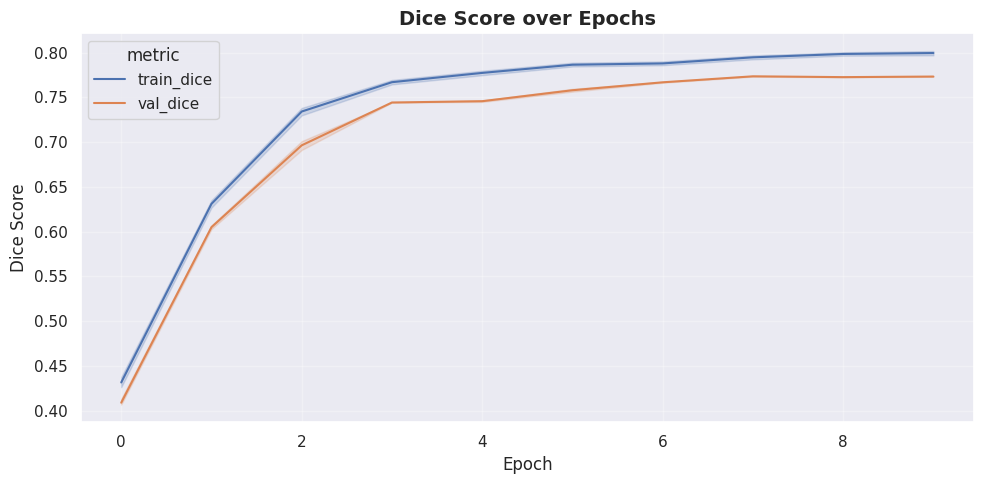

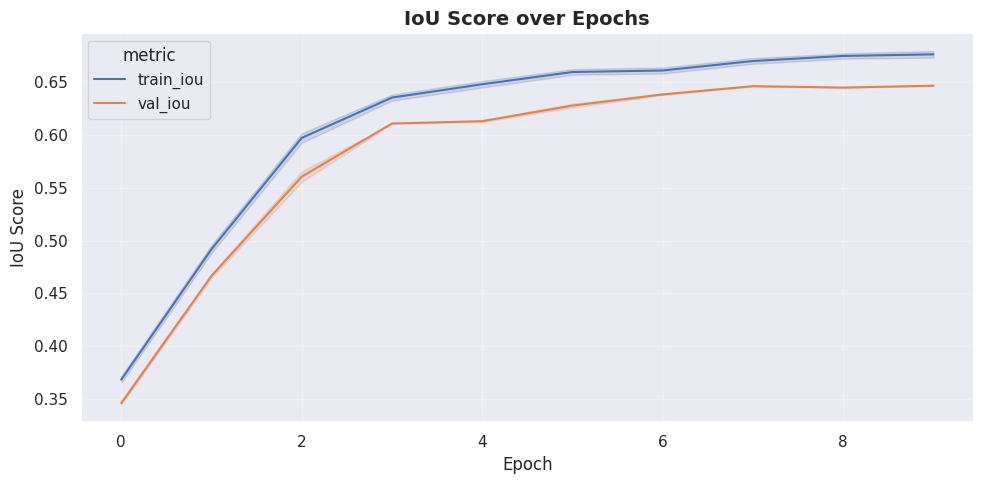

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # Ensure display is available
sns.set()

# Read the metrics.csv using the trainer's logger directory
# We need to find the latest version directory within the logger's save_dir
log_base_dir = Path(trainer.logger.save_dir)
# Correct the path to include the 'lightning_logs' subdirectory
log_version_parent_dir = log_base_dir / 'lightning_logs'
version_dirs = sorted([
    d for d in log_version_parent_dir.iterdir()
    if d.is_dir() and d.name.startswith('version_')])

# Get the latest version directory
latest_version_log_dir = version_dirs[-1]
metrics_path = latest_version_log_dir / 'metrics.csv'
print(f"Loading metrics from: {metrics_path}")
metrics = pd.read_csv(metrics_path)

# Remove any columns that are entirely NaN (e.g., from different logging frequencies)
display(metrics.dropna(axis=1, how="all").head())

# Fill any NaN values by propagating the last valid observation forward (useful for sparse logging)
metrics.ffill(inplace=True)

# Melt the DataFrame to long-form for plotting
# We assume 'epoch' is a reliable identifier for x-axis
metrics_melted = metrics.reset_index().melt(
    id_vars='epoch', var_name='metric', value_name='value')

# Define metric groups based on available metrics from VesuviusSegmentationModel
metric_groups = {
    'Loss': [c for c in metrics.columns if '_loss' in c],
    'Dice Score': [c for c in metrics.columns if '_dice' in c],
    'IoU Score': [c for c in metrics.columns if '_iou' in c],
}

# Plot metrics for each group in a separate chart
for title, metric_list in metric_groups.items():
    # Filter melted DataFrame for the current group
    group_metrics = metrics_melted[metrics_melted['metric'].isin(metric_list)]

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=group_metrics, x='epoch', y='value', hue='metric')
    plt.title(f'{title} over Epochs', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(title, fontsize=12)
    plt.grid(True, alpha=0.3)

    # Apply log scale only for Loss, not for Dice/IoU which are typically 0-1
    if title == 'Loss':
        plt.yscale('log')

    plt.tight_layout()
plt.show()

## 🔮 Inference

Predict on new 3D volumes:

In [13]:
def visualize_prediction(
    image: np.ndarray,
    pred: np.ndarray,
    target: np.ndarray = None,
    figsize: Tuple[int, int] = (18, 6)
):
    """Visualize prediction vs ground truth."""
    n_plots = 3 if target is not None else 2
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    
    # Image
    if len(image.shape) == 3:
        mid_channel = image.shape[0] // 2
        axes[0].imshow(image[mid_channel], cmap='gray')
    else:
        axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    
    # Prediction
    axes[1].imshow(pred, cmap='hot', vmin=0, vmax=1)
    axes[1].set_title('Prediction')
    axes[1].axis('off')
    
    # Ground truth (if available)
    if target is not None:
        axes[2].imshow(target, cmap='hot', vmin=0, vmax=1)
        axes[2].set_title('Ground Truth')
        axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [14]:
# Helper function for nearest neighbor resizing without cv2
def resize_nearest_neighbor(image_array: np.ndarray, target_height: int, target_width: int) -> np.ndarray:
    """Resizes a 2D numpy array using nearest neighbor interpolation."""
    original_h, original_w = image_array.shape
    
    # Create coordinate grids for the target image by sampling original indices
    y_indices = np.linspace(0, original_h - 1, target_height, dtype=np.int32)
    x_indices = np.linspace(0, original_w - 1, target_width, dtype=np.int32)

    # Use outer product for broadcasting to create the full 2D grid and sample from the image
    resized_image = image_array[np.ix_(y_indices, x_indices)]
    return resized_image

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

Inference for (320, 320, 320) generated (320, 320, 320) slices of predictions with values [0 1].


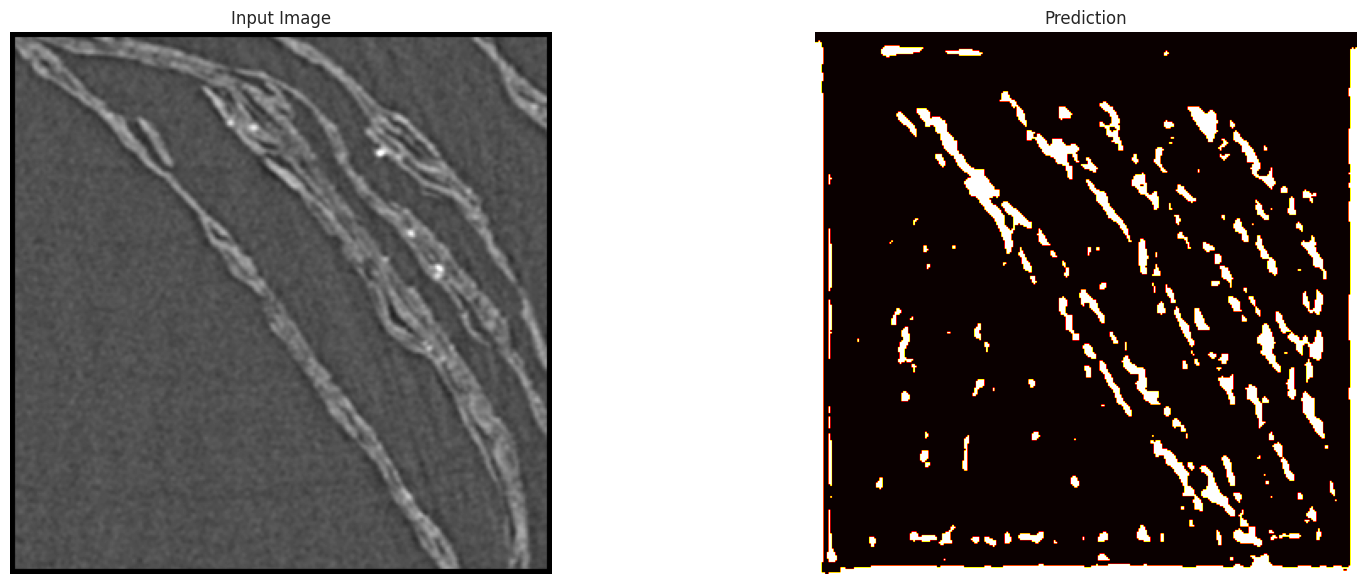

In [15]:
# import cv2 # Removed: Not needed with custom resize

model.eval()
model.to(DEVICE)

# --- Setup volume_path (assuming it's a test image, for demonstration) ---
# In a real scenario, this block would typically be part of an inference function
# where the path to the volume is passed as an argument.
# For this notebook's flow, we'll get the first test image.
test_volume_files = sorted([f.name for f in TEST_IMAGES_DIR.glob("*.tif")])
if not test_volume_files:
    raise FileNotFoundError(f"No TIFF files found in {TEST_IMAGES_DIR} for inference.")

test_filenames = []
for test_volume_file in tqdm(test_volume_files):
    volume_path = TEST_IMAGES_DIR / test_volume_file
    # Load volume
    volume = tifffile.imread(str(volume_path))

    # Setup inference parameters
    # Use VesuviusSliceDataset's static method for axis mapping
    num_slices = volume.shape[VesuviusSliceDataset._map_axis_name_to_index(SLICE_AXIS)]
    # Use the validation transform from the data module
    transform = data_module.val_transform

    predictions_list_2d = [] # Store 2D slices here
    # Iterate directly over slices, as NUM_ADJACENT_SLICES = 1
    for i in tqdm(range(num_slices)):
        # Extract a single slice directly
        # _extract_slice_from_volume returns (1, H, W), squeeze to (H, W)
        image_input_for_transform = \
            VesuviusSliceDataset._extract_slice_from_volume(volume, i, SLICE_AXIS).squeeze(0)

        # Store original dimensions before resizing
        original_h, original_w = image_input_for_transform.shape

        transformed = transform(image=image_input_for_transform)
        image_tensor = transformed["image"].unsqueeze(0).to(DEVICE) # Add batch dimension (B, C, H, W)

        # Predict
        with torch.no_grad():
            logits = model(image_tensor) # Model now outputs logits (B, C, H, W) for multi-class
            # Apply softmax to get probabilities, then argmax to get predicted class for each pixel
            pred_proba = torch.softmax(logits, dim=1) # (B, C, H, W)
            pred_class = torch.argmax(pred_proba, dim=1).cpu().numpy()[0] # (H, W) predicted class labels

        # Resize prediction back to original slice dimensions using nearest neighbor interpolation
        # Using custom numpy resize instead of Albumentations with cv2
        pred_class_original_size = resize_nearest_neighbor(pred_class, original_h, original_w)

        predictions_list_2d.append(pred_class_original_size)

    # Stack the 2D slices into a 3D volume. This volume has its first dimension as the slice axis.
    # If SLICE_AXIS='z', predictions will be (Z, Y, X)
    # If SLICE_AXIS='y', predictions will be (Y, Z, X)
    # If SLICE_AXIS='x', predictions will be (X, Z, Y)
    predictions_volume = np.stack(predictions_list_2d, axis=0).astype(np.uint8)

    print(f"Inference for {volume.shape} generated {predictions_volume.shape} slices"
          f" of predictions with values {np.unique(predictions_volume)}.")

    # Save predictions as a TIFF volume within the new subfolder
    # This saves the volume in the orientation (SLICE_AXIS_DIM, OtherDim1, OtherDim2)
    test_filename = f"{Path(volume_path).stem}.tif"
    tifffile.imwrite(test_filename, predictions_volume)
    test_filenames.append(test_filename)

# Optional: Visualize a sample prediction
if len(predictions_list_2d) > 0:
    # Take a slice from the original volume corresponding to the first prediction
    original_slice_for_display = VesuviusSliceDataset._extract_slice_from_volume(volume, 0, SLICE_AXIS).squeeze(0)
    # For visualization, ensure the prediction is a single channel (class labels)
    visualize_prediction(original_slice_for_display, predictions_list_2d[0])

### Export submission

In [16]:
import zipfile

with zipfile.ZipFile('submission.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    for filename in tqdm(test_filenames, desc="Zipping files"):
        if not os.path.exists(filename):
            print(f"Missing <> {filename}")
            continue
        zipf.write(filename)
        os.remove(filename)

Zipping files:   0%|          | 0/1 [00:00<?, ?it/s]